In [2]:
from openparticle import ParticleOperator
from openparticle.utils import get_fock_basis, generate_matrix

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import List

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)

In [3]:
Ef, Eb, g = 1, 1, 1
Lambda_max = 20

In [4]:
from functools import reduce
from evolution import evolve_statevector

def compute_expectation_value(
        statevector,
        cutoff,
        operator: str,
        order: int,
        n_steps: int,
        t: float, 
        g: float = 1.0,
        Ef: float = 1.0,
        Eb: float = 1.0
):
    
    if operator == 'number_op_fermion':
        number_operator_ferm = ParticleOperator('b0^ b0')
        number_operator_ferm_matrix = generate_matrix(number_operator_ferm, get_fock_basis(number_operator_ferm, cutoff))
        padded_matrix_operator = reduce(np.kron, [number_operator_ferm_matrix, np.eye(cutoff + 1)])
    elif operator == 'number_op_boson':
        number_operator_bose = ParticleOperator('a0^ a0')
        number_operator_bose_matrix = generate_matrix(number_operator_bose, get_fock_basis(number_operator_bose, cutoff))
        padded_matrix_operator = reduce(np.kron, [np.eye(2), number_operator_bose_matrix])
    elif operator == 'position_op':
        a_dagger_a = ParticleOperator('a0^') + ParticleOperator('a0')
        a_dagger_a_matrix = generate_matrix(a_dagger_a, get_fock_basis(a_dagger_a, cutoff))
        padded_matrix_operator = reduce(np.kron, [np.eye(2), a_dagger_a_matrix])

    evolved_statevector = evolve_statevector(
        t=t, Ef=Ef,Eb=Eb, g = g, Lambda = cutoff, order = order, n_steps = n_steps, statevector = statevector
    )

    return evolved_statevector.T.conjugate() @ padded_matrix_operator @ evolved_statevector
     

In [5]:
from states import get_initial_state

def compute_expectation_values_t(
        fermion_state: str,
        boson_state: str,
        cutoff: int,
        order:int,
        n_steps:int,
        operator: str,
        t_values: List,
        g: float = 1.0,
        Ef: float = 1.0,
        Eb: float = 1.0
):
    """
    Args:

    - fermion_state (str): 'single_fermion' or 'plus_state'
    - boson_state (str): 'zero_boson' or 'coherent_boson'
    - trotterization (str): 'exact' or 'first_order' or 'second_order'
    - expectation_value_type (str): 'number_op_boson' or 'number_op_fermion' or 'position_op'

    """

    expectation_values = []

    statevector = get_initial_state(fermion_state, boson_state, cutoff, g)
    
    for t in t_values:
        exp_val = compute_expectation_value(
                statevector=statevector, cutoff=cutoff, operator=operator, 
                t = t, order = order, n_steps = n_steps,
                g = g, Ef = Ef, Eb = Eb
            )
        expectation_values.append(exp_val[0].real)

    return np.array(expectation_values)


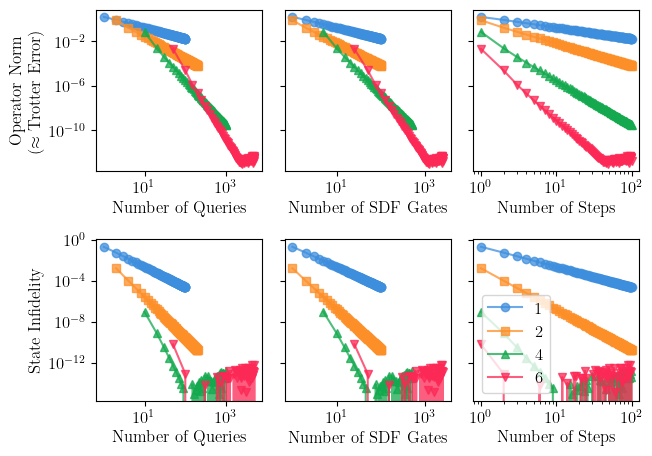

In [15]:
from evolution import estimate_cost, estimate_state_fidelity, estimate_operator_norm_error
import matplotlib.pyplot as plt
Lambda = 7
Ef, Eb, g = 1, 1, 1

# t = max_qpe_time(Ef, Eb, g, Lambda)
t = 1

BLUE = "#3D8EDD"
ORANGE = "#FD8F29"
GREEN = "#14A94E"
RED_ORANGE = "#FC4E14"
RED = "#FC2855"
PURPLE = "#DF6DF7"
PINK = "#FD57CC"
LIGHT_YELLOW = "#F7F0C3"
YELLOW = "#FFE74C"

COLORS = [BLUE, ORANGE, GREEN, RED]
MARKERS = ["o", "s", "^", "v"]
suzuki_trotter_orders = [1, 2, 4, 6]


fig, axes = plt.subplots(2, 3, figsize=(17 / 2.54, 12 / 2.54))
axes[0][0].set_ylabel("Operator Norm\n($\\approx$ Trotter Error)")
axes[0][0].set_xlabel("Number of Queries")
axes[0][1].set_ylabel("")
axes[0][1].set_xlabel("Number of SDF Gates")
axes[0][2].set_xlabel("Number of Steps")

axes[1][0].set_ylabel("State Infidelity")
axes[1][0].set_xlabel("Number of Queries")
axes[1][1].set_ylabel("")
axes[1][1].set_xlabel("Number of SDF Gates")
axes[1][2].set_xlabel("Number of Steps")

fermion_state = 'single_fermion'
boson_state = 'zero_boson'
initial_state = get_initial_state(fermion_state, boson_state, Lambda, g)

for color, marker, suzuki in zip(COLORS, MARKERS, suzuki_trotter_orders):
    numbers_of_queries = []
    numbers_of_sdf_gates = []
    operator_norms = []
    state_infidelities = []
    num_trotter_steps = []
    num_steps = 1
    num_queries, num_sdf_gates = estimate_cost(suzuki, num_steps)
    while num_steps <= 100:
        numbers_of_queries.append(num_queries)
        numbers_of_sdf_gates.append(num_sdf_gates)
        operator_norms.append(estimate_operator_norm_error(Ef, Eb, g, t, Lambda, suzuki, num_steps))
        state_infidelities.append(1 - estimate_state_fidelity(Ef, Eb, g, t, Lambda, suzuki, num_steps, initial_state))
        num_trotter_steps.append(num_steps)
        num_steps += 1
        num_queries, num_sdf_gates = estimate_cost(suzuki, num_steps)
    axes[0][0].plot(numbers_of_queries, operator_norms, marker=marker, color=color, ms=6, alpha=0.75, label=suzuki)
    axes[0][1].plot(numbers_of_sdf_gates, operator_norms, marker=marker, color=color, ms=6, alpha=0.75, label=suzuki)
    axes[0][2].plot(num_trotter_steps, operator_norms, marker=marker, color=color, ms=6, alpha=0.75, label=suzuki)
    axes[1][0].plot(numbers_of_queries, state_infidelities, marker=marker, color=color, ms=6, alpha=0.75, label=suzuki)
    axes[1][1].plot(numbers_of_sdf_gates, state_infidelities, marker=marker, color=color, ms=6, alpha=0.75, label=suzuki)
    axes[1][2].plot(num_trotter_steps, state_infidelities, marker=marker, color=color, ms=6, alpha=0.75, label=suzuki)

axes[0][0].set_yscale("log")
axes[0][1].set_yscale("log")
axes[0][2].set_yscale("log")
axes[1][0].set_yscale("log")
axes[1][1].set_yscale("log")
axes[1][2].set_yscale("log")

axes[0][0].set_xscale("log")
axes[0][1].set_xscale("log")
axes[0][2].set_xscale("log")
axes[1][0].set_xscale("log")
axes[1][1].set_xscale("log")
axes[1][2].set_xscale("log")
# axes[0][0].set_xlim(0, 100)
# axes[0][1].set_xlim(0, 100)
# axes[1][0].set_xlim(0, 100)
# axes[1][1].set_xlim(0, 100)

axes[0][1].set_yticklabels([])
axes[0][2].set_yticklabels([])
axes[1][1].set_yticklabels([])
axes[1][2].set_yticklabels([])

axes[1][2].legend(loc="lower left")
plt.tight_layout()
plt.savefig("trotter_error_estimates.pdf", dpi=300)

In [15]:
def get_plot_y_label(operator_expectation):
    if operator_expectation == 'number_op_fermion':
        return r'$\langle b^\dagger b \rangle$'
    elif operator_expectation == 'number_op_boson':
        return r'$\langle a^\dagger a \rangle$'
    elif operator_expectation == 'position_op':
        return r'$\langle a^\dagger + a \rangle$'
    
def get_plot_title(fermion_state, boson_state):
    title_str = r'$|\psi(0)\rangle = $'
    if fermion_state == 'single_fermion':
        if boson_state == 'zero_boson':
            title_str += r'$|1_f 0_b\rangle$'
        elif boson_state == 'coherent_boson':
            title_str += r'$|1_f \alpha_b\rangle$'
    elif fermion_state == 'plus_fermion':
        if boson_state == 'zero_boson':
            title_str += r'$|+_f 0_b\rangle$'
        elif boson_state == 'coherent_boson':
            title_str += r'$|+_f \alpha_b\rangle$'
    return title_str

In [16]:
fermion_state = 'single_fermion'
boson_state = 'zero_boson'
Lambda = 7
order = 2
num_steps = 15
# operator_expectation = 'number_op_boson'
operator_expectation = 'position_op'
t_arr = np.arange(0, 10, 0.1)

exp_vals_trotterized = compute_expectation_values_t(
    fermion_state, boson_state, Lambda, order, num_steps, operator_expectation, t_arr
)

exp_vals_exact = compute_expectation_values_t(
    fermion_state, boson_state, Lambda, 0, 1, operator_expectation, t_arr
)

Text(0.5, 0, '$t$')

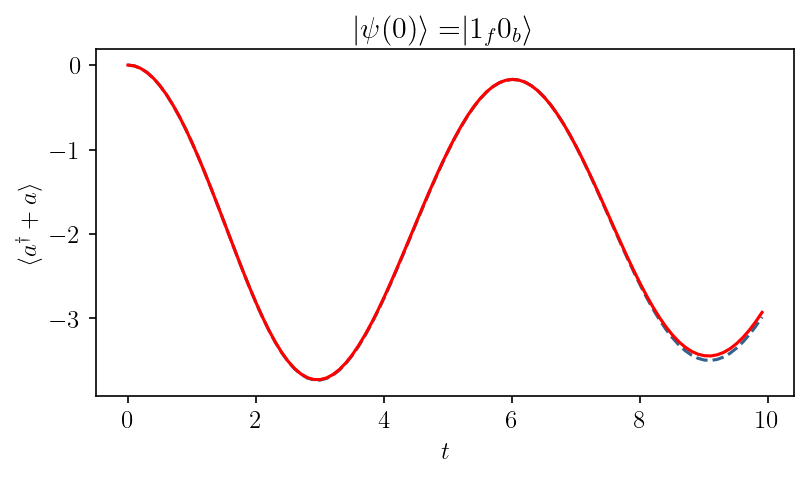

In [17]:
plt.figure(figsize=(6, 3), dpi=150)

# if trotterization_approximation == 'exact':
#     linestyle = 'solid'
# elif trotterization_approximation == 'first_order':
#     linestyle = 'dashed'
# elif trotterization_approximation == 'second_order':
#     linestyle = 'dotted'
linestyle = 'dashed'

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=1, vmax=Lambda_max)

plt.plot(t_arr, exp_vals_trotterized, linestyle = linestyle, color = cmap(norm(Lambda)))
plt.plot(t_arr, exp_vals_exact, linestyle = 'solid', color = 'red')

plt.ylabel(
    get_plot_y_label(operator_expectation)
)
plt.title(get_plot_title(fermion_state, boson_state))
plt.xlabel(r'$t$')


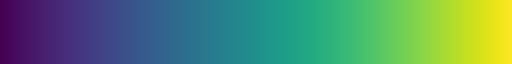

In [34]:
cmap

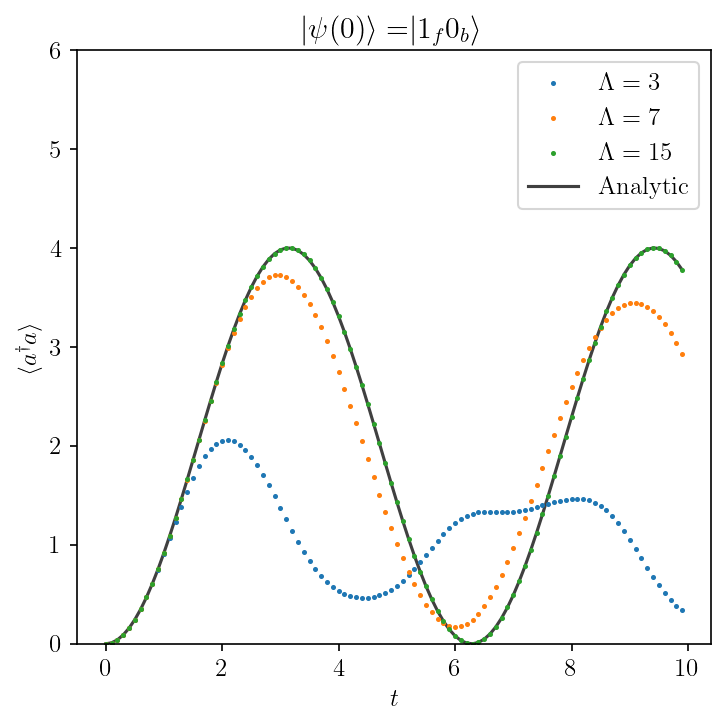

In [ ]:
t_arr = np.arange(0, 10, 0.1)
Lambda_max = 2**4

fermion_state = 'single_fermion'
boson_state = 'zero_boson'
trotterization_approximation = 'exact'
operator_expectation = 'number_op_boson'


exp_vals_lambda3 = compute_expectation_values_t(
    fermion_state, boson_state, 3, trotterization_approximation, operator_expectation, t_arr
)
exp_vals_lambda7 = compute_expectation_values_t(
    fermion_state, boson_state, 7, trotterization_approximation, operator_expectation, t_arr
)
exp_vals_lambda15 = compute_expectation_values_t(
    fermion_state, boson_state, 15, trotterization_approximation, operator_expectation, t_arr
)


cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=1, vmax=Lambda_max)

plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(t_arr, exp_vals_lambda3, marker = 'o', s = 2, label = r'$\Lambda = 3$')
plt.scatter(t_arr, exp_vals_lambda7, marker = 'o', s = 2, label = r'$\Lambda = 7$')
plt.scatter(t_arr, exp_vals_lambda15, marker = 'o', s = 2, label = r'$\Lambda = 15$')
plt.plot(t_arr, -2*np.cos(t_arr) + 2, color = 'k', alpha = 0.75, label = 'Analytic', zorder = -1)
plt.ylabel(
    get_plot_y_label(operator_expectation)
)
plt.ylim(0, 6)
plt.title(get_plot_title(fermion_state, boson_state))
plt.xlabel(r'$t$')
plt.legend()
plt.tight_layout()
plt.savefig('./static_yukawa_plots/exact.pdf')
plt.show()

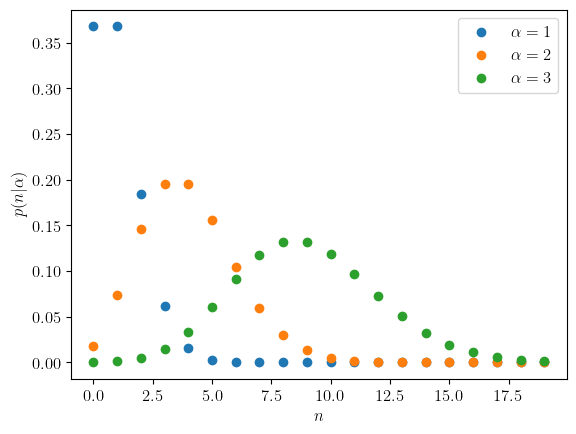

In [54]:
def p(n, alpha):
    return (np.exp(-np.abs(alpha)**2 / 2) * (alpha ** n) / np.sqrt(scipy.special.factorial(n)))**2

Lambda = 20

n = np.arange(0, Lambda, 1)

plt.scatter(n, p(n, 1), label = r'$\alpha = 1$')
plt.scatter(n, p(n, 2), label = r'$\alpha = 2$')
plt.scatter(n, p(n, 3), label = r'$\alpha = 3$')
plt.ylabel(r'$p(n|\alpha)$')
plt.xlabel(r'$n$')
plt.legend()

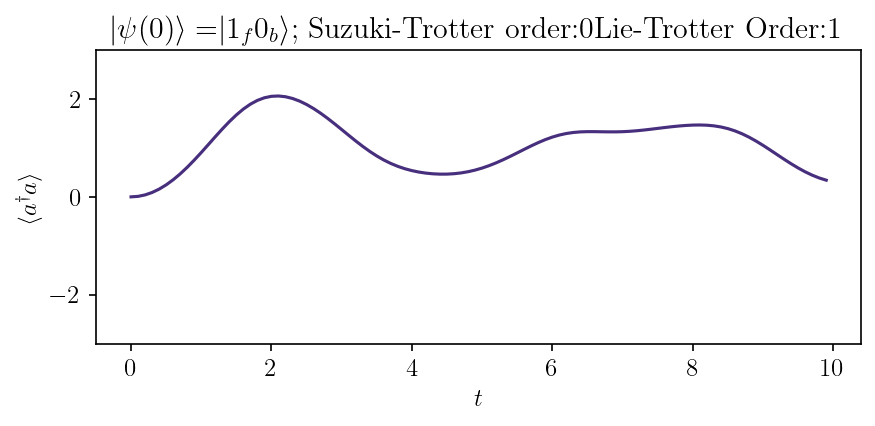

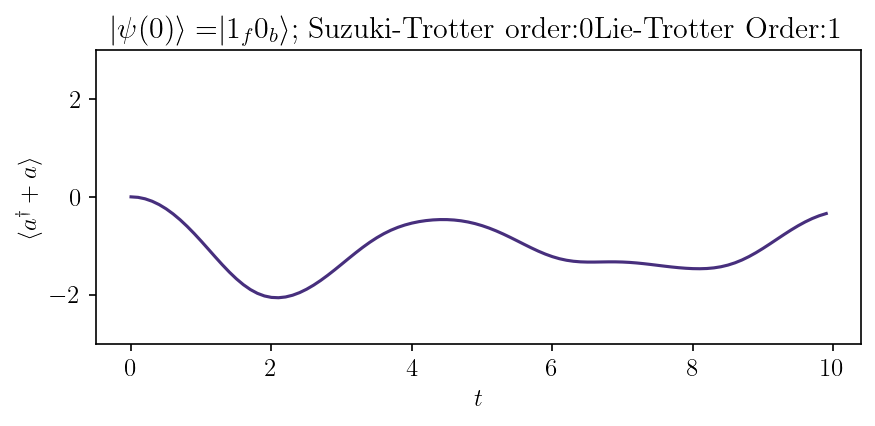

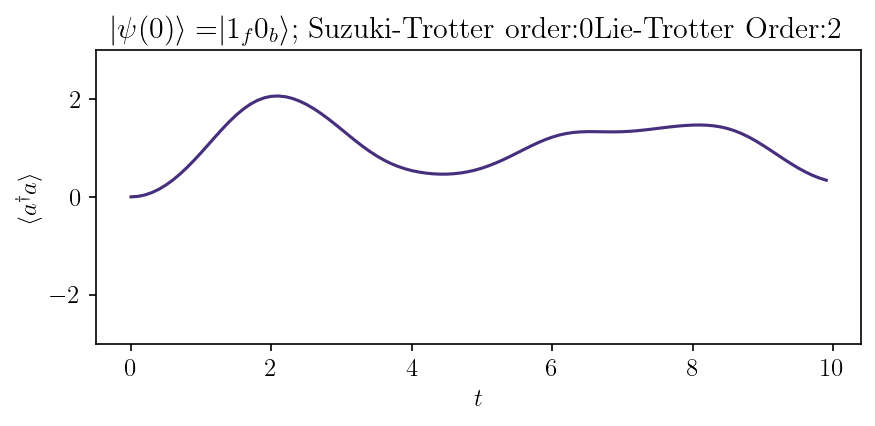

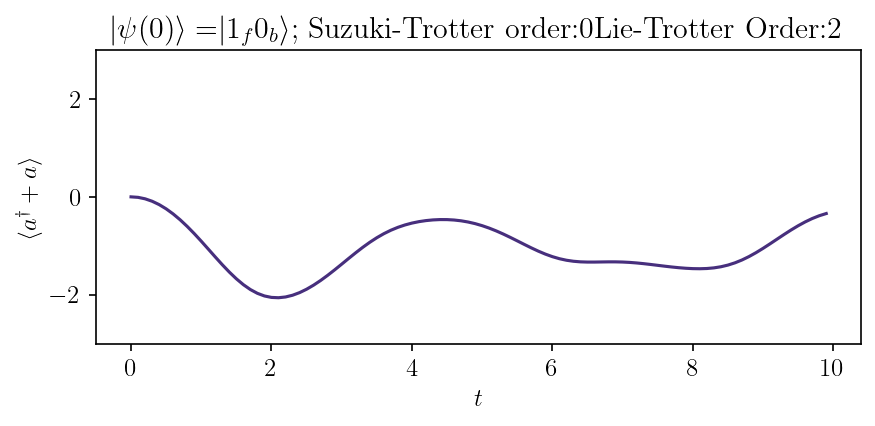

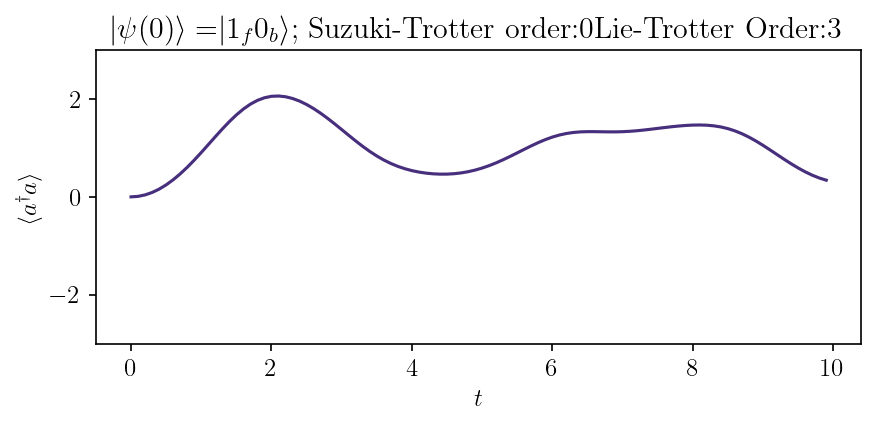

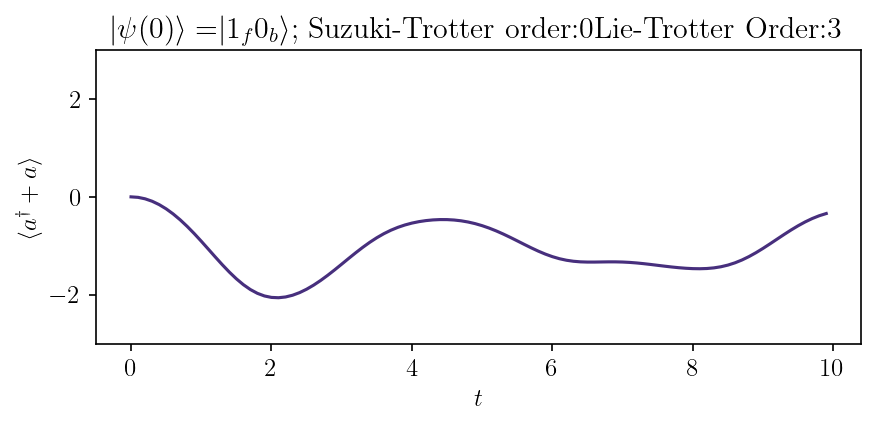

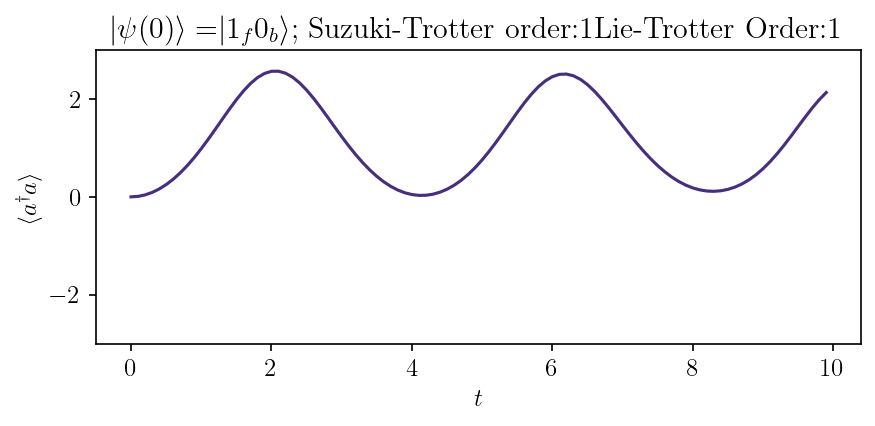

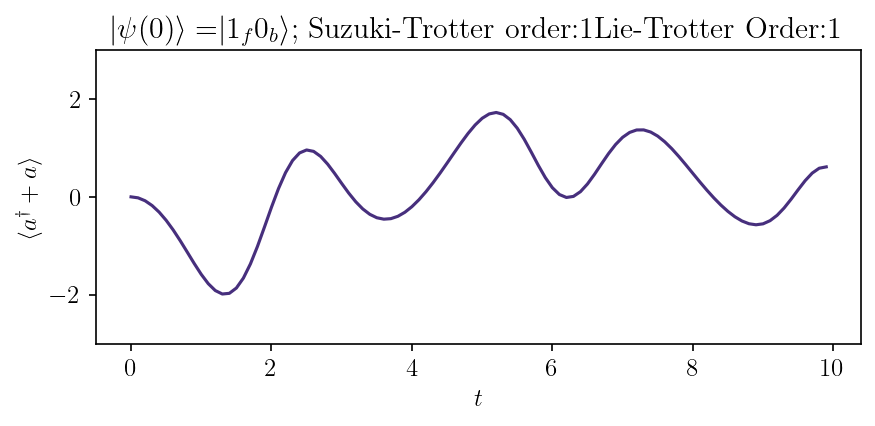

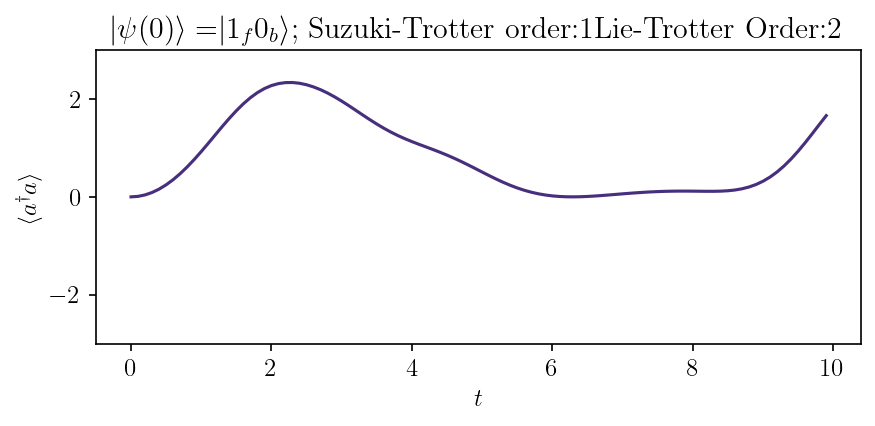

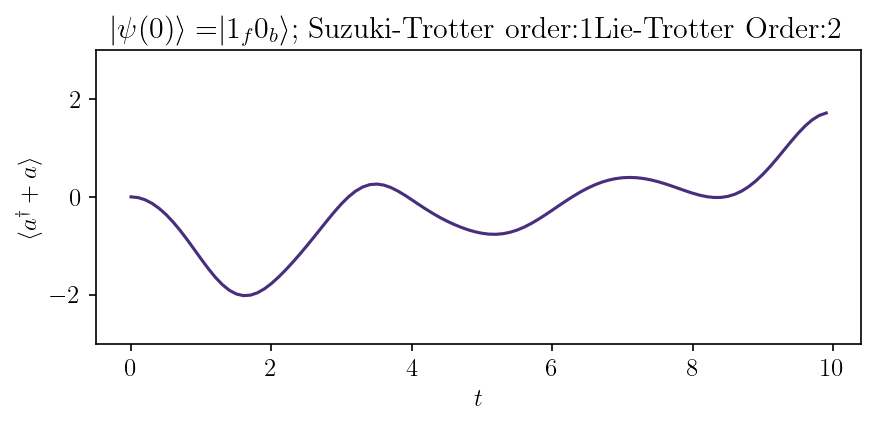

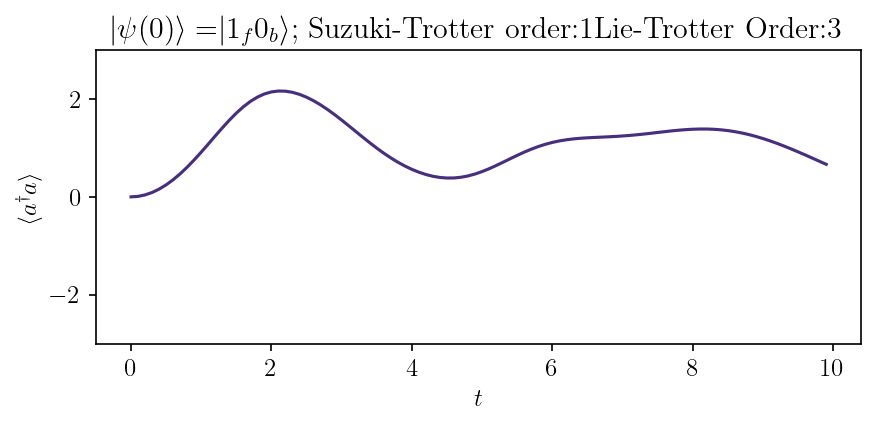

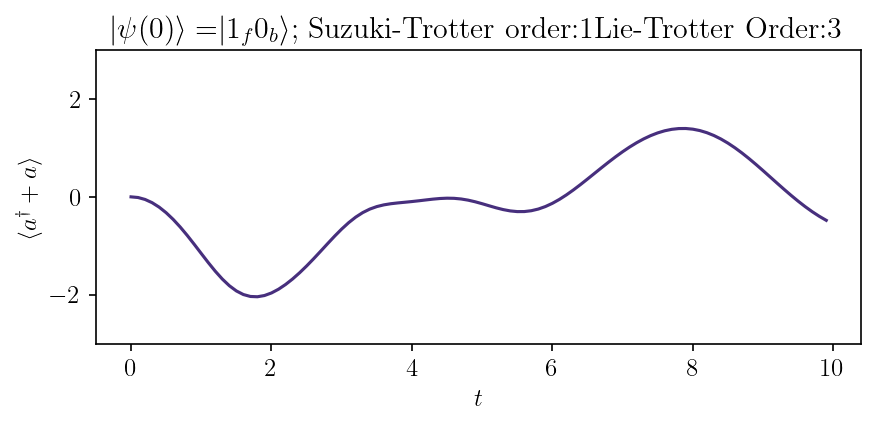

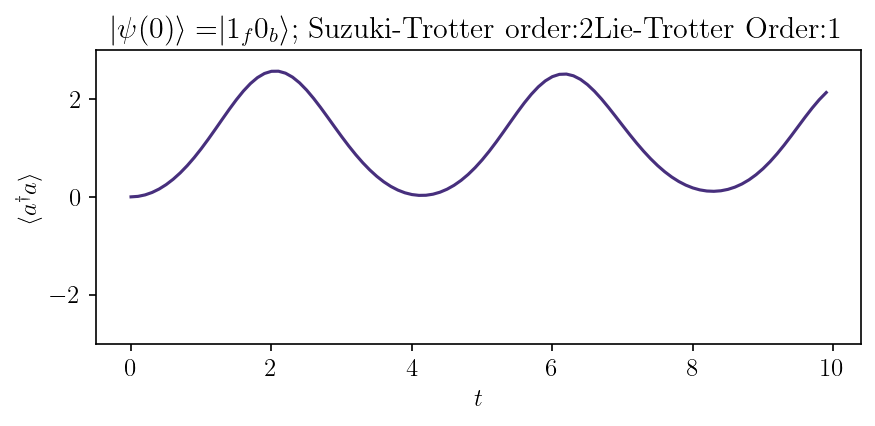

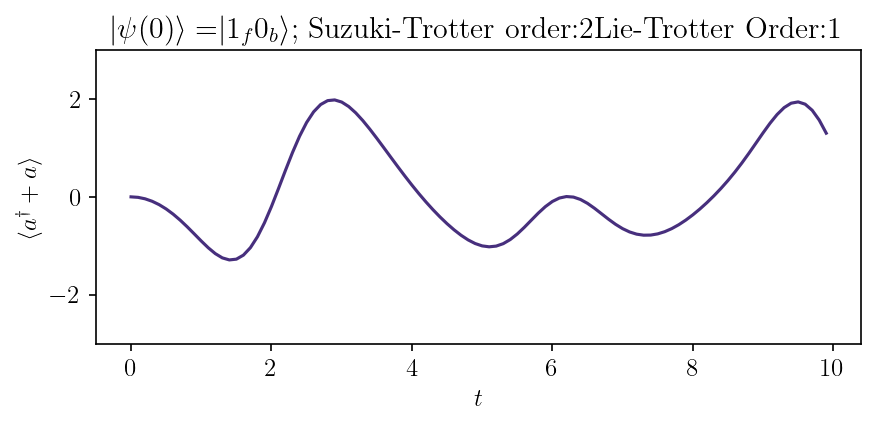

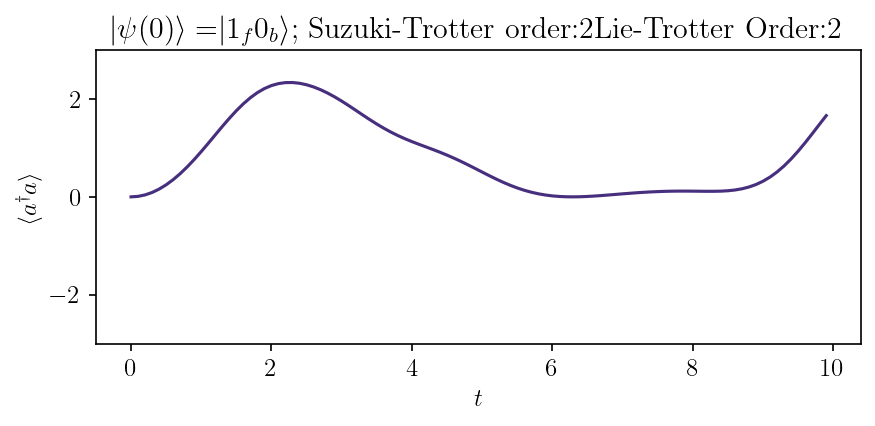

KeyboardInterrupt: 

In [95]:
t_arr = np.arange(0, 10, 0.1)
Lambda_max = 2**4

for fermion_state in ['single_fermion']:
    for boson_state in ['zero_boson']:
        for Lambda in [10]:
            for suzuki_trotter_order in [0, 1, 2]:
                for lie_trotter_order in [1, 2, 3]:
                    for operator_expectation in ['number_op_boson', 'position_op']:
                        exp_vals = compute_expectation_values_t(
                            fermion_state, boson_state, Lambda, suzuki_trotter_order, lie_trotter_order, operator_expectation, t_arr
                        )
                        

                        cmap = mpl.colormaps['viridis']
                        norm = mpl.colors.Normalize(vmin=1, vmax=Lambda_max)

                        plt.figure(figsize=(6, 3), dpi=150)
                        plt.plot(t_arr, exp_vals, linestyle = 'solid', color = cmap(norm(Lambda)))
                        plt.ylabel(
                            get_plot_y_label(operator_expectation)
                        )
                        plt.ylim(-Lambda, Lambda)
                        plt.title(get_plot_title(fermion_state, boson_state) + '; Suzuki-Trotter order:' + str(suzuki_trotter_order) + 'Lie-Trotter Order:' + str(lie_trotter_order))
                        plt.xlabel(r'$t$')
                        plt.tight_layout()
                        # plt.savefig(
                        #     './static_yukawa_plots/' + fermion_state + " " + boson_state + " " +
                        #     trotterization_approximation + " " + operator_expectation + " " +
                        #     'Lambda_' + str(Lambda) + '.pdf'
                        #             )
                        plt.show()

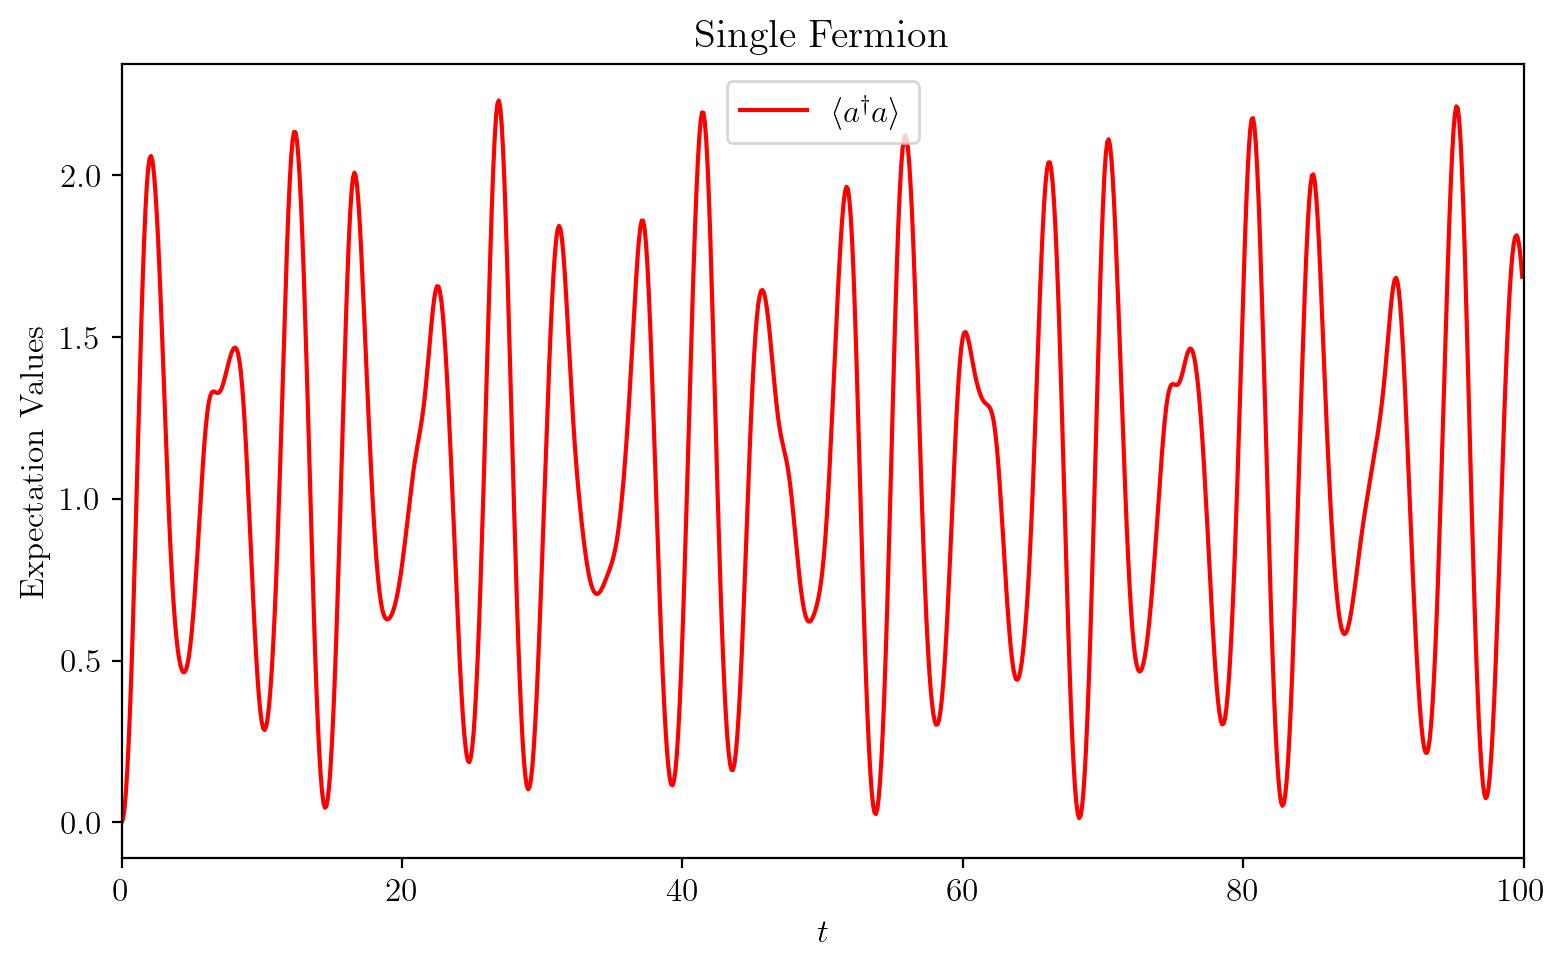

In [390]:
plt.figure(figsize=(8,5), dpi=200)

# plt.plot(t_arr, trotterized_expvals[0], color = 'k', linestyle = 'dashed')
# plt.plot(t_arr, trotterized_expvals[1], color = 'r', zorder = 1, linestyle = 'dashed')
# plt.plot(t_arr, trotterized_expvals[2], color = 'g', zorder = 2,  linestyle = 'dashed')

# plt.plot(t_arr, exact_expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
# plt.plot(t_arr, exact_expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')
# plt.plot(t_arr, exact_expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')


plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.legend()
plt.tight_layout()
# plt.savefig('./single_fermion.pdf')

(array([ 24,  26,  49,  51,  75, 925, 949, 951, 974, 976]), {})


(0.0, 0.1)

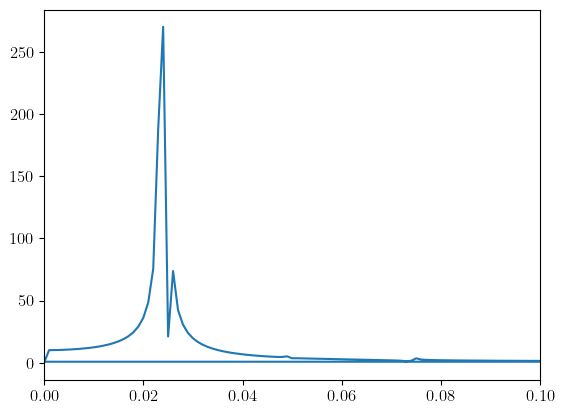

In [375]:
# freq_arr = np.fft.fftfreq(len(t_arr), d=t_arr[1] - t_arr[0])

N = len(t_arr)
freq_arr = np.fft.fftfreq(N)


fft_arr = scipy.fft.fft(np.array(expvals[1]).T[0] - np.average(expvals[1])).real

print(scipy.signal.find_peaks(np.abs(fft_arr)))
plt.plot(freq_arr, np.abs(fft_arr))
plt.xlim(0, 0.1)


In [376]:
fermion_state = np.array([[1, 0]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1
boson_state = displacement_operator(alpha = -1j * g / 2, Lambda = Lambda) @ boson_state

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
trotterized_expvals = compute_trotterized_expectations(statevector, t_arr, Ef, Eb, g, Lambda)
exact_expvals = compute_exact_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

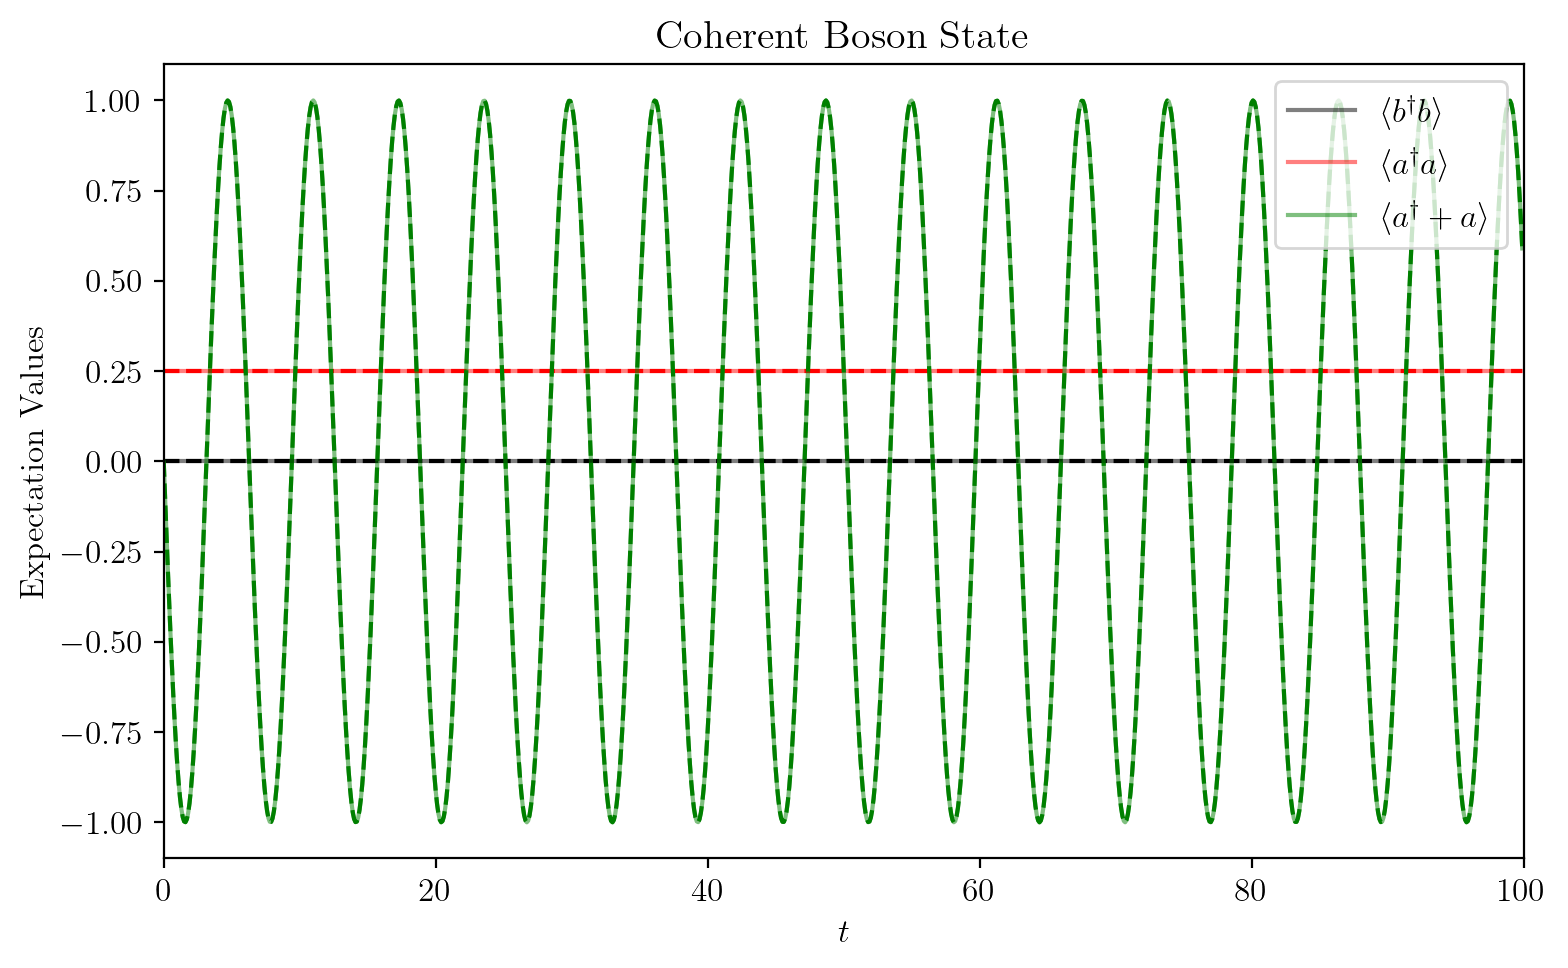

In [377]:
plt.figure(figsize=(8,5), dpi=200)

plt.plot(t_arr, trotterized_expvals[0], color = 'k', linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[1], color = 'r', zorder = 1, linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[2], color = 'g', zorder = 2,  linestyle = 'dashed')

plt.plot(t_arr, exact_expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$', alpha = 0.5)
plt.plot(t_arr, exact_expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$', alpha = 0.5)
plt.plot(t_arr, exact_expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$', alpha = 0.5)


plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title("Coherent Boson State")
plt.legend()
plt.tight_layout()
# plt.savefig('./coherent_state.pdf')

In [378]:
fermion_state = np.array([[0, 1]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1
boson_state = displacement_operator(alpha = -1j * g / 2, Lambda = Lambda) @ boson_state

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
trotterized_expvals = compute_trotterized_expectations(statevector, t_arr, Ef, Eb, g, Lambda)
exact_expvals = compute_exact_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

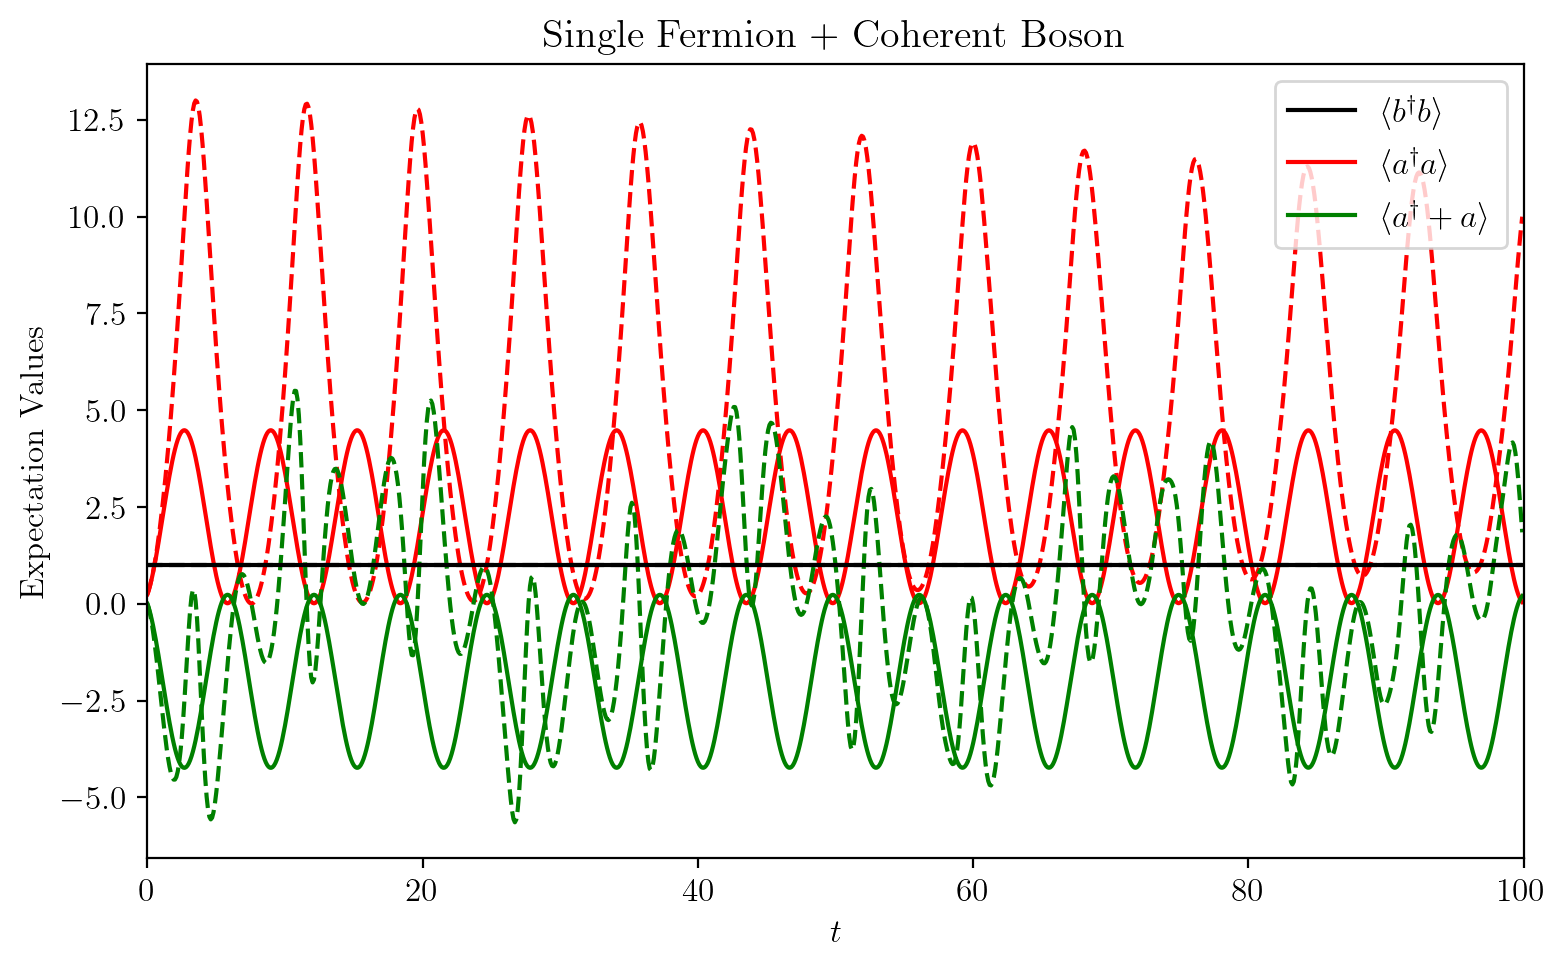

In [379]:
plt.figure(figsize=(8,5), dpi=200)


plt.plot(t_arr, trotterized_expvals[0], color = 'k', linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[1], color = 'r', zorder = 1, linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[2], color = 'g', zorder = 2,  linestyle = 'dashed')

plt.plot(t_arr, exact_expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
plt.plot(t_arr, exact_expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')
plt.plot(t_arr, exact_expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')

plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title(r"Single Fermion $+$ Coherent Boson")
plt.legend()
plt.tight_layout()
# plt.savefig("./fermion_plus_coherent_state.pdf")